In [1]:
import sys
import os
import h5py 
import scipy.io as sio
import pprint
import matplotlib
import matplotlib.cm as cm

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Data/'

       
import numpy as np
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilitiesi 
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(device)

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', 'checkpoints')

#%load_ext autoreload
#%autoreload 2

Running on Computer: [wireless-10-104-47-95.umd.edu]
Invoking __init__.py for NDNT.utils
cpu
Save_dir = checkpoints


In [2]:
import NTdatasets.HN.HNdatasets as datasets

num_lags = 12

inclMUs = True #set false for now
fn = 'ki_0126_V2_py.mat'
data = datasets.HNdataset(filename=fn, datadir=datadir, drift_interval=90)
print(len(data), data.NC)

./Data/ ki_0126_V2_py.mat
Loaded ki_0126_V2_py.mat
190541 frames, 26 units, 870 trials with 192 frames each
190541 26


In [3]:
stim_to_correct = {}
for sig, strength, side, choice in zip(data.TRsignal, data.TRstrength, data.TRcued, data.TRchoice):
    if side < 0: side = 0 # make -1 sides into 0 for indexing purposes
    side = 1 - side
    
    stim = sig[side]*strength[side] # stimulus is signal (-1 or +1) times it strength
    
    if stim not in stim_to_correct: stim_to_correct[stim] = [] # initialize if not created

    '''sig[side]*choice'''
    if choice > 0: # choice and signal have the same sign
        stim_to_correct[stim].append(1)
    else: # choice and signal have different signs
        stim_to_correct[stim].append(0)

In [4]:
sides = data.TRcued.copy() # copy the array so we don't corrupt the raw data
sides[sides == 1] = 0 # make all +1 sides index into column 0
sides[sides == -1] = 1 # make all the -1 sides index into column 1
# create the array of stims which are the signal*strength at the given cued side
X = [sig[side]*strength[side] for sig, side, strength in zip(data.TRsignal, sides, data.TRstrength)]

# copy the array so we don't corrupt the raw data
Y = data.TRchoice.copy()
#  replace all -1 with 0 to make our choice counts easy to calculate by averaging
Y[Y == -1] = 0

stims = np.unique(X) # get the unique stimulus values
# get the mean choices for each unique stimulus value
responses = [Y[np.where(X == stim)].mean() for stim in stims]
list(zip(stims, responses)) # print this out for reference

[(-0.5, 0.0),
 (-0.25, 0.0),
 (-0.125, 0.06666666666666667),
 (-0.06, 0.25609756097560976),
 (-0.03, 0.5),
 (-0.0, 0.5283018867924528),
 (0.03, 0.7027027027027027),
 (0.06, 0.7065217391304348),
 (0.125, 0.9230769230769231),
 (0.25, 1.0),
 (0.5, 1.0)]

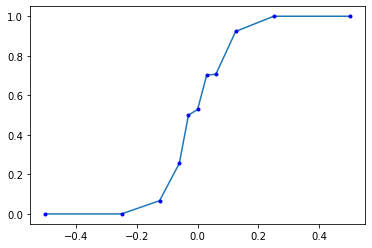

In [5]:
plt.plot(stims, responses)
plt.plot(stims, responses, 'b.')
plt.show()

In [6]:
stims_means = np.array([(stim, np.mean(correct)) for stim, correct in stim_to_correct.items()])
sorted_stims_means = stims_means[stims_means[:, 0].argsort()]
sorted_stims_means

array([[-0.5       ,  0.        ],
       [-0.25      ,  0.        ],
       [-0.125     ,  0.06666667],
       [-0.06      ,  0.25609756],
       [-0.03      ,  0.5       ],
       [ 0.        ,  0.52830189],
       [ 0.03      ,  0.7027027 ],
       [ 0.06      ,  0.70652174],
       [ 0.125     ,  0.92307692],
       [ 0.25      ,  1.        ],
       [ 0.5       ,  1.        ]])

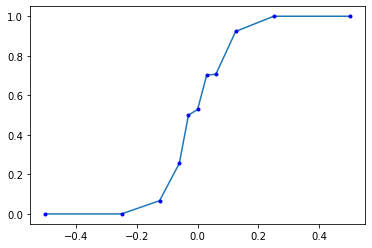

In [7]:
plt.plot(sorted_stims_means[:,0], sorted_stims_means[:,1])
plt.plot(sorted_stims_means[:,0], sorted_stims_means[:,1], 'b.')
plt.show()